In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import cross_validation, linear_model, preprocessing
from sklearn.metrics import precision_recall_curve, precision_score, recall_score

%matplotlib inline

In [2]:
raw_data = pd.read_csv('./learndata-latest.csv')
raw_data.head()

,connected,id_i,id_j,length_i,length_j,side_i,side_j,sw_width_i,sw_width_j,curbtype_i,...,surftype_i,surftype_j,intersects,near_angle,near_distance,near_line,near_line_srid,bid_i,bid_j,intersects_street
0,0,289092,299107,297.230378,313.835648,W,S,60,60,410C,...,PCC,AC,f,-2.283203,34.436532,"LINESTRING(-122.319447001456 47.6008471113961,...",4326,NaN,3352,0
1,0,293102,331808,431.833749,434.510666,W,W,52,72,AR,...,PCC,PCC,f,3.141594,26.949339,"LINESTRING(-122.350055372668 47.6554398660144,...",4326,2831,2831,0
2,0,313868,313874,218.799534,180.349589,S,S,0,0,410B,...,UIMPRV,UIMPRV,f,-0.191456,4.190603,"LINESTRING(-122.362966756884 47.5713328446345,...",4326,NaN,NaN,0
3,0,319890,322466,225.852123,272.643093,SE,E,60,60,410C,...,PCC,PCC,f,3.723988,13.995332,"LINESTRING(-122.395081951736 47.5849380800841,...",4326,575,575,0
4,0,319292,319294,313.080031,623.754118,N,N,0,0,NONE,...,UIMPRV,UIMPRV,f,-3.141596,26.933899,"LINESTRING(-122.368266891496 47.5538036466461,...",4326,723,723,0


In [3]:
# Remove features that we shouldn't learn (encoded geometries and sidewalk ID numbers)
near_line = raw_data['near_line']  # Save for later
del raw_data['near_line']
del raw_data['id_i']
del raw_data['id_j']

In [39]:
# Binarizes categorical variables 
# (e.g. if 3 categories, makes 3 cols with 1s and 0s)
# X = pd.get_dummies(raw_data)  

# Turn categorical variables into integer labels
label_encoder = preprocessing.LabelEncoder()
raw_data['curbtype_i'] = label_encoder.fit_transform(raw_data['curbtype_i'])
raw_data['curbtype_j'] = label_encoder.fit_transform(raw_data['curbtype_j'])
raw_data['side_i'] = label_encoder.fit_transform(raw_data['side_i'])
raw_data['side_j'] = label_encoder.fit_transform(raw_data['side_j'])
raw_data['surftype_i'] = label_encoder.fit_transform(raw_data['surftype_i'])
raw_data['surftype_j'] = label_encoder.fit_transform(raw_data['surftype_j'])
raw_data['intersects'] = label_encoder.fit_transform(raw_data['intersects'])

X = raw_data

X['same_curbtype'] = (X['curbtype_i'] == X['curbtype_j']).astype(int)
X['same_surftype'] = (X['surftype_i'] == X['surftype_j']).astype(int)
X['same_block'] = (X['bid_i'] == X['bid_j']).astype(int)
X['same_side'] = (X['side_i'] == X['side_j']).astype(int)

X['length_diff'] = abs(X['length_i'] - X['length_j'])
X['sw_width_diff'] = abs(X['sw_width_i'] - X['sw_width_j']).astype(float)

y = X['connected']
X = X.drop('connected', 1)
X = X.drop('curbtype_i', 1)
X = X.drop('curbtype_j', 1)
X = X.drop('surftype_i', 1)
X = X.drop('surftype_j', 1)

X['near_angle'] = abs(X['near_angle'])

del X['bid_i']  # This has NaN and will cause errors in sklearn
del X['bid_j']

del X['side_i']
del X['side_j']
del X['length_i']
del X['length_j']
del X['sw_width_i']
del X['sw_width_j']

# This is the same for all rows
del X['near_line_srid']

X.head()

,intersects,near_angle,near_distance,intersects_street,same_curbtype,same_surftype,same_block,same_side,length_diff,sw_width_diff
0,0,2.283203,34.436532,0,0,0,0,0,16.605270,0
1,0,3.141594,26.949339,0,1,0,1,1,2.676917,20
2,0,0.191456,4.190603,0,1,0,0,1,38.449945,0
3,0,3.723988,13.995332,0,1,0,1,0,46.790971,0
4,0,3.141596,26.933899,0,1,0,1,1,310.674087,0


In [292]:
Xl = X[46:51]
print Xl.to_latex()

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  intersects &  near\_angle &  near\_distance &  intersects\_street &  same\_curbtype &  same\_surftype &  same\_block &  same\_side &  length\_diff &  sw\_width\_diff \\
\midrule
46 &           0 &    3.097889 &      -0.245471 &                  0 &              1 &              0 &           1 &          1 &     0.829867 &       1.728248 \\
47 &           0 &    1.570795 &      -0.457384 &                  0 &              1 &              0 &           1 &          0 &    -0.542791 &      -0.499391 \\
48 &           0 &    2.177396 &      -0.494970 &                  0 &              0 &              0 &           1 &          0 &    -0.557851 &       2.842067 \\
49 &           0 &    4.703532 &      -0.499786 &                  0 &              1 &              0 &           1 &          0 &     0.879883 &      -0.499391 \\
50 &           1 &    1.570484 &      -0.479618 &                  0 &              1 &              0 &           1 &

In [40]:
# Scaling appropriate features by subtracting mean and scaling to unit variance
scaler = preprocessing.StandardScaler()

X['near_distance'] = scaler.fit_transform(X['near_distance'])
X['length_diff'] = scaler.fit_transform(X['length_diff'])
X['sw_width_diff'] = scaler.fit_transform(X['sw_width_diff'])

In [220]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.9, random_state=6883)

### Logistic Regression

In [221]:
logistic = linear_model.LogisticRegression(penalty='l1', C=2e-2)
logistic.fit(X_train, y_train)
print logistic.score(X_test, y_test)
print
for colname, value in zip(list(X.columns), logistic.coef_[0]):
    print '{}: {}'.format(colname, value)

0.973645706222

intersects: 6.8585865777
near_angle: -0.337459994001
near_distance: 0.109189394408
intersects_street: -2.24581591677
same_curbtype: 0.0
same_surftype: 0.0
same_block: 1.2471247048
same_side: 1.69246096755
length_diff: -0.0534437970611
sw_width_diff: 0.0


Precision score (what fraction of predicted connections are true): 0.997759641543
Recall score (what fraction of connections were found?): 0.847117964743


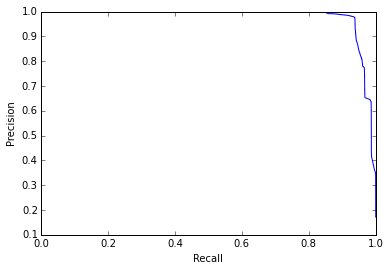

In [222]:
y_pred = logistic.predict(X_test)
y_prob = logistic.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
print "Precision score (what fraction of predicted connections are true): {}".format(precision_score(y_test, y_pred))
print "Recall score (what fraction of connections were found?): {}".format(recall_score(y_test, y_pred))

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [277]:
# Cross validation - splits into 10 distinct train-test folds and fits
logistic_scores = cross_validation.cross_val_score(logistic, X, y, cv=10, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f)" % (logistic_scores.mean(), logistic_scores.std() * 2))

Accuracy: 0.95 (+/- 0.21)


### Logistic Regression with random features

In [259]:
poly = preprocessing.PolynomialFeatures(2)
Xp = poly.fit_transform(X)
#Xp_train, Xp_test, yp_train, yp_test = cross_validation.train_test_split(Xp, y, test_size=0.9, random_state=6883)
Xp_train, Xp_test, yp_train, yp_test = cross_validation.train_test_split(Xp, y, test_size=0.9)

In [260]:
logisticp = linear_model.LogisticRegression(penalty='l1', C=1e-2)
logisticp.fit(Xp_train, yp_train)
print 'Fit score: {}'.format(logisticp.score(Xp_test, yp_test))
bases = []
bases_names = []
coefficients = []
for bases_list, coefficient in zip(list(poly.powers_), logisticp.coef_[0]):
    if coefficient:
        bases.append(str(bases_list))
        base_str = ', '.join(X.columns[np.where(np.logical_and(bases_list, X.columns))])
        bases_names.append(base_str)
        coefficients.append(coefficient)

logisticp_np = np.column_stack([bases, bases_names, coefficients])
logisticp_df = pd.DataFrame(logisticp_np, columns=['bases', 'columns', 'coefficient'])

# Sort by absolute value of coefficient value
logisticp_df.coefficient = logisticp_df.coefficient.astype(float)
logisticp_df.reindex(logisticp_df.coefficient.abs().sort_values(ascending=False).index)

Fit score: 0.985362581182


,bases,columns,coefficient
3,[1 1 0 0 0 0 0 0 0 0],"intersects, near_angle",2.553956
2,[2 0 0 0 0 0 0 0 0 0],intersects,1.961741
5,[0 1 0 1 0 0 0 0 0 0],"near_angle, intersects_street",-1.310491
0,[0 0 0 0 0 0 0 0 0 0],,-1.190301
7,[0 1 0 0 0 0 0 1 0 0],"near_angle, same_side",0.728959
6,[0 1 0 0 0 0 1 0 0 0],"near_angle, same_block",0.395454
1,[1 0 0 0 0 0 0 0 0 0],intersects,0.316879
4,[0 2 0 0 0 0 0 0 0 0],near_angle,-0.082444
8,[0 1 0 0 0 0 0 0 0 1],"near_angle, sw_width_diff",-0.050279
9,[0 0 2 0 0 0 0 0 0 0],near_distance,0.003045


In [297]:
cf = logisticp_df.reindex(logisticp_df.coefficient.abs().sort_values(ascending=False).index)[['columns', 'coefficient']]
print cf.to_latex()

\begin{tabular}{llr}
\toprule
{} &                        columns &  coefficient \\
\midrule
3 &         intersects, near\_angle &     2.553956 \\
2 &                     intersects &     1.961741 \\
5 &  near\_angle, intersects\_street &    -1.310491 \\
0 &                                &    -1.190301 \\
7 &          near\_angle, same\_side &     0.728959 \\
6 &         near\_angle, same\_block &     0.395454 \\
1 &                     intersects &     0.316879 \\
4 &                     near\_angle &    -0.082444 \\
8 &      near\_angle, sw\_width\_diff &    -0.050279 \\
9 &                  near\_distance &     0.003045 \\
\bottomrule
\end{tabular}



Precision score (what fraction of predicted connections are true): 0.977059178102
Recall score (what fraction of connections were found?): 0.936005434783


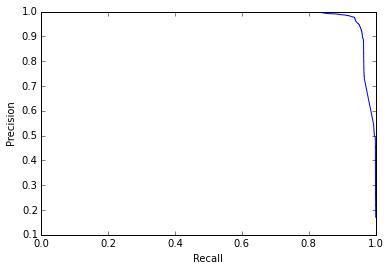

In [261]:
y_predp = logisticp.predict(Xp_test)
y_probp = logisticp.predict_proba(Xp_test)[:,1]
precisionp, recallp, thresholdsp = precision_recall_curve(yp_test, y_probp)
print "Precision score (what fraction of predicted connections are true): {}".format(precision_score(yp_test, y_predp))
print "Recall score (what fraction of connections were found?): {}".format(recall_score(yp_test, y_predp))

plt.plot(recallp, precisionp)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [276]:
# Cross validation - splits into 10 distinct train-test folds and fits
logisticp_scores = cross_validation.cross_val_score(logisticp, X, y, cv=10, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f)" % (logisticp_scores.mean(), logisticp_scores.std() * 2))

Accuracy: 0.95 (+/- 0.21)


In [293]:
print logistic_scores
print logisticp_scores

[ 0.63503878  0.994587    0.99791808  0.99682507  0.99708531  0.99765784
  0.99724131  0.99750156  0.96299188  0.95414086]
[ 0.64211732  0.99474314  0.99786603  0.99672097  0.99708531  0.99765784
  0.9970331   0.99729336  0.96283573  0.95346416]


### Support Vector Machines

In [278]:
from sklearn import svm

y_train_cls = y_train.copy()
y_train_cls.loc[y_train == 0] = -1
y_test_cls = y_test.copy()
y_test_cls.loc[y_test == 0] = -1

In [279]:
svmc = svm.LinearSVC(penalty='l1', dual=False, C=1e-2)
svmc.fit(X_train, y_train)
print svmc.score(X_test, y_test)
svmc_pred = svmc.predict(X_test)
print svmc.coef_
print 'Precision: {}'.format(precision_score(y_test, svmc_pred))
print 'Recall: {}'.format(recall_score(y_test, svmc_pred))

0.973859686663
[[  2.08961491e+00  -9.30735915e-02   3.81828168e-02  -3.98930172e-01
    2.71183573e-04   0.00000000e+00   3.33815565e-01   4.70197087e-01
   -3.31922859e-02  -9.00199481e-03]]
Precision: 0.999318773793
Recall: 0.847050032268


### Recovering True positives, False Positives, etc for visualization

In [280]:
X_pred = logistic.predict(X)

X_out = X.copy()
X_acc = X_pred == y

true_positives = X_out[np.logical_and(X_pred, X_acc)]
false_positives = X_out[np.logical_and(X_pred, np.logical_not(X_acc))]
true_negatives = X_out[np.logical_and(np.logical_not(X_pred), X_acc)]
false_negatives = X_out[np.logical_and(np.logical_not(X_pred), np.logical_not(X_acc))]

print true_positives.shape
print true_negatives.shape
print false_positives.shape
print false_negatives.shape

(27732, 10)
(159340, 10)
(66, 10)
(4987, 10)


In [181]:
# We can export the data to GeoJSON for visualization. It's probably simplest to export all rows
# as features and have a 'truth_value' property that's 'false positive', 'true positive', etc.

# Actually, let's write a shapefile
from shapely import wkt
from shapely.geometry import mapping
import fiona
from fiona import crs

epsg = crs.from_epsg(4269)  # 

# Note: this takes a while to run
schema = {'geometry': 'LineString',
          'properties': {'scored': 'str'}}

with fiona.open('./learndata-predictions-latest.shp', 'w', 'ESRI Shapefile', schema, crs=epsg) as c:
    for i in range(len(X_pred)):
        feature = {}
        feature['type'] = 'Feature'
        geom = wkt.loads(near_line[i])
        feature['geometry'] = mapping(geom)
        if X_acc[i]:
            if X_pred[i]:
                properties = {'scored': 'true positive'}
            else:
                properties = {'scored': 'true negative'}
        else:
            if X_pred[i]:
                properties = {'scored': 'false positive'}
            else:
                properties = {'scored': 'false negative'}
        feature['properties'] = properties
        
        c.write(feature)

In [198]:
# Export errors as geojson for visualizing on github
import json

geojson = {}
geojson['type'] = 'FeatureCollection'
geojson['features'] = []

for i in range(len(X_pred)):
    if not X_acc[i]:
        feature = {}
        feature['type'] = 'Feature'
        geom = wkt.loads(near_line[i])
        feature['geometry'] = mapping(geom)
        if X_pred[i]:
            properties = {'predicted': 1,
                          'type': 'false positive',
                          'stroke': '#FC0000',
                          'stroke-width': 5}
        else:
            properties = {'predicted': 0,
                          'type': 'false negative',
                          'stroke': '#093CA8',
                          'stroke-width': 5}
        feature['properties'] = properties
        geojson['features'].append(feature)
        
with open('./learndata-errors.geojson', 'w') as f:
    json.dump(geojson, f)